In [1]:
import pandas as pd
import scipy

from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

import requests
from io import StringIO, BytesIO
from os import path

import numbers

from utils import *


In [2]:
USE_AUTOGRAD = False

if USE_AUTOGRAD:
    import autograd.numpy as np 
    from autograd import grad, jacobian
    from autograd.builtins import isinstance, tuple

else:
    import numpy as np

In [3]:
# stuff for display

from IPython.lib.pretty import pretty, pprint

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 120)

In [4]:
def download_sheet(file_id, sheet_id):
    r = requests.get(f'https://docs.google.com/spreadsheets/d/{file_id}/export?format=csv&id={file_id}&gid={sheet_id}')
    df = pd.read_csv(BytesIO(r.content), thousands=',')
    return df
    

In [5]:
refresh_rp_file = True

rp_file_id = "1kBrPl0pdAO8gjOf_NrTgAPseFtqQA27fdfEbMBBeAhs"

sheet_ids = {
    "data_1_9":   "1682088244",
    "data_10_29": "1691041080",
}

local_files = {
    "data":       './data/rp-data.pickle',
    "natures" :   './data/natures.pickle',
    "subskills":  './data/subskills.pickle',
    "mainskills": './data/mainskills.pickle',
    "pokedex":    './data/pokedex.pickle',
}


if (refresh_rp_file):

    data_1_9 = download_sheet(rp_file_id, sheet_ids["data_1_9"])
    data_10_29 = download_sheet(rp_file_id, sheet_ids["data_10_29"])
    
    data = pd.concat([data_1_9, data_10_29], axis = 0)
    data = data.dropna(subset=["Pokemon","Level","RP","Nature","MS lvl"])
    data = data.fillna({'Amnt':0 ,'Ing2P':0, 'Help skill bonus': 1, 'RP Multiplier': 1, 'ModelRP': -1, 'Difference': -1})
    data = data.fillna({'Sub Skill 1':'','Sub Skill 2':'', 'Ingredient 2': '', 'Source':''})


    # avoid second food item
    data = data[ data["Level"] < 30 ]
    
    # avoid a bug in RP of freshly catched mon with skill up unlocked.
    data = data[ ~( (data["Sub Skill 1"] == "Skill Level Up S") & (data["MS lvl"] == 2) & (data["Level"] > 9) )]
    data = data[ ~( (data["Sub Skill 1"] == "Skill Level Up M") & (data["MS lvl"] == 3) & (data["Level"] > 9) )]
    
    data.to_pickle(local_files["data"])
    
else:
    
    data = pd.read_pickle(local_files["data"])
    
    
    
natures = pd.read_pickle(local_files["natures"])
mainskills = pd.read_pickle(local_files["mainskills"])
subskills = pd.read_pickle(local_files["subskills"])
pokedex = pd.read_pickle(local_files["pokedex"])



In [6]:
data.describe()
data.head()

# natures.head()
# mainskills.head()
# subskills.head()
# pokedex.head()

,Level,RP,MS lvl,ModelRP,Difference,Freq1,FreqL,Inv,Berry1,BerryL,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,BerryD,IngD,Dupes,Amnt,Ing2P,Help skill bonus,RP Multiplier
count,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.0,5388.0,5388.0,5388.000000,5388.000000
mean,9.407572,553.999629,1.393467,554.027489,0.027860,4005.270973,3872.457511,12.001114,28.004083,36.445249,108.783222,0.996091,0.989512,0.995189,1.000817,1.005605,0.206850,30.429595,52.860987,145.508537,1.0,0.0,0.0,0.989607,1.025191
std,6.210092,321.425270,0.889458,321.445872,0.816323,941.615694,1003.578748,3.314861,2.616079,6.835966,15.676164,0.290566,0.059458,0.045421,0.118524,0.118237,0.043777,32.333612,24.926046,54.504152,0.0,0.0,0.0,0.034614,0.066190
min,1.000000,245.000000,1.000000,245.070000,-9.710000,2200.000000,1489.118400,7.000000,24.000000,24.000000,90.000000,0.520000,0.890000,0.920000,0.800000,0.800000,0.080000,5.990000,25.000000,90.000000,1.0,0.0,0.0,0.790000,1.000000
25%,5.000000,348.000000,1.000000,348.105000,-0.270000,3400.000000,3091.200000,10.000000,26.000000,32.000000,98.000000,0.800000,1.000000,1.000000,1.000000,1.000000,0.180000,11.990000,35.000000,101.000000,1.0,0.0,0.0,1.000000,1.000000
50%,8.000000,433.000000,1.000000,432.820000,-0.010000,4000.000000,3861.000000,11.000000,28.000000,35.000000,103.000000,0.930000,1.000000,1.000000,1.000000,1.000000,0.200000,18.180000,43.000000,121.000000,1.0,0.0,0.0,1.000000,1.000000
75%,12.000000,657.000000,1.000000,657.160000,0.270000,4500.000000,4482.000000,14.000000,30.000000,40.000000,115.000000,1.160000,1.000000,1.000000,1.000000,1.000000,0.230000,43.050000,66.000000,202.000000,1.0,0.0,0.0,1.000000,1.000000
max,29.000000,3432.000000,6.000000,3432.820000,7.140000,6300.000000,6916.140000,23.000000,35.000000,67.000000,151.000000,2.410000,1.120000,1.080000,1.200000,1.200000,0.380000,422.030000,195.000000,302.000000,1.0,0.0,0.0,1.000000,1.440000


,Pokemon,Level,RP,Nature,MS lvl,Source,ModelRP,Difference,Nature2,ID,NatureP,NatureN,Freq1,FreqL,Type,Class,MSkill,Inv,Berry1,BerryL,Ing1,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,RPneutral,IDNeutral,BerryD,IngD,Dupes,DupeMatch,Sub Skill 1,Sub Skill 2,Ingredient 2,Amnt,Ing2P,Help skill bonus,RP Multiplier
0,Arbok,8.0,531.0,Hardy,1,Questions help guides,530.76,-0.24,Neutral,ArbokNeutral81,-,-,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.0,1.0,0.26,22.79,531.00,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
1,Arbok,9.0,574.0,Naughty,1,Rate My Mon,574.45,0.45,Naughty,ArbokNaughty91,Speed of Help,Main Skill Chance,3700.0,3276.72,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,1.09,0.90,1.00,1.0,0.8,0.26,22.79,538.39,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
2,Arbok,8.0,538.0,Quiet,1,Questions help guides,538.14,0.14,Quiet,ArbokQuiet81,Ingredient Finding,Exp Gains,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.2,1.0,0.26,22.79,530.62,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
3,Arcanine,5.0,958.0,Calm,3,,957.99,-0.01,Calm,ArcanineCalm53,Main Skill Chance,Speed of Help,2500.0,2728.00,Fire,Skills,Extra Helpful S,16.0,27.0,31,Fiery Herb,130.0,1.31,1.11,1.00,1.0,1.2,0.14,84.46,937.91,ArcanineNeutral53,31.0,130.0,1,True,,,,0.0,0.0,1.0,1.0
4,Arcanine,3.0,715.0,Lax,2,pokemon sleep general,715.00,0.00,Lax,ArcanineLax32,Energy Recovery,Main Skill Chance,2500.0,2490.00,Fire,Skills,Extra Helpful S,16.0,27.0,29,Fiery Herb,130.0,1.44,1.00,1.08,1.0,0.8,0.14,61.17,750.12,ArcanineNeutral32,29.0,130.0,1,True,,,,0.0,0.0,1.0,1.0


In [7]:
# nature and subskill with known effects on production

nature_soh_effect = 0.1
subskill_help_s_effect = 0.07
subskill_help_m_effect = 0.14

subskill_ing_s_effect = 0.18
subskill_ing_m_effect = 0.36

subskill_trigger_s_effect = 0.18
subskill_trigger_m_effect = 0.36

In [8]:
# Here we build the initial guess

initial = {
    'Nature Ingredient Finding': 0.2, # Idea: We start at 0.25 because it's about midpoint between 0.18 and  0.36
    'Nature Main Skill Chance': 0.2,  # If it still goes to 0.2 it is what it is.
    'Nature Energy Recovery': 0.08,
}


In [9]:
# Load Initial guess for the ing% and skillProduct ( skill% * skillValue ) from pokedex 

pokemon_to_position = {}

previous_ing_fractions = []
previous_skl_products = []

for record in pokedex.to_dict(orient='records') :   
    
    pokemon_to_position[record["Pokemon"]] = len(previous_ing_fractions) 
    
    # Last fit
    previous_ing_fractions.append(record["Last fit ing"])
    previous_skl_products.append(record["Last fit skl"])
    
initial["Pokemons ing fractions"] = previous_ing_fractions
initial["Pokemons skill products"] = previous_skl_products

In [10]:
# Intial guess for skill growth
# We assume that the conversion from level 1 to level L
# Has the shape a*exp(b*L). Initial guess for a,b fitted on charge strength 

for record in mainskills.to_dict(orient='records') :   
    skillname = record["Skill"]
    initial[ skillname ] = [0.7462, 0.3224]


In [11]:
# Initial guess for ingredient growth.
# Comes from a previous fit
# Numpy poly convention is highest degree first

initial["Ing Growth Poly"] = [0.00018948, 0.00306669, -0.00173611] 

In [12]:
# Add our guess for the sub skills that multiply the whole rp
 
bonus = subskills[ subskills["RP Multiplier Guess"] >0 ]

for record in bonus.to_dict(orient='records') :
    initial[record["Subskill"]] = record["RP Multiplier Guess"]

In [13]:
# Pack the dictionary into a 1-D vector.
# Also store information on how to unpack that vector
    
x0, unpack_info = pack(initial)


In [14]:
from types import SimpleNamespace 
computed = SimpleNamespace()

In [15]:
# All the formula "ifs" will be implemented as one-hot vector  (0,1)

# Specialty (Class)

classes = ["Ingredients","Berries","Skills"]
computed.has_class = dict( [(c, (data["Class"] == c).astype(int).to_numpy() ) for c in classes])

# Natures

traits = natures["TraitPos"].unique()

natures_with_positive_trait = dict( [( t, natures[ natures["TraitPos"] == t ]["Nature"].tolist() ) for t in traits ] )
natures_with_negative_trait = dict( [( t, natures[ natures["TraitNeg"] == t ]["Nature"].tolist() ) for t in traits ] )

computed.has_positive_trait = dict( [(t, data["Nature"].isin(natures_with_positive_trait[t]).astype(int).to_numpy() ) for t in traits] )
computed.has_negative_trait = dict( [(t, data["Nature"].isin(natures_with_negative_trait[t]).astype(int).to_numpy() ) for t in traits] )

# Subskills

subs = subskills["Subskill"].unique()

computed.has_subskill = dict([ (s, 
                          ( ( (data["Sub Skill 1"] == s) & (data["Level"] >= 10) ) | 
                            ( (data["Sub Skill 2"] == s) & (data["Level"] >= 25) ) 
                          ).astype(int).to_numpy()
                      )
       for s in subs
     ])


In [16]:

# We could redo that work but it's not related to the optimisation
computed.ing1_power_base      = data["Ing1P"]
computed.berry_power_base     = data["Berry1"]
computed.berry_power_at_level = data["BerryL"]


In [17]:
# Here we will reproduce the Help/hr information as a test of using those one-hot vectors.

data_period_base  = data["Freq1"]
data_period_level = data_period_base * ((501-data["Level"])/500.0) 

nature_correction = (
    1 
    - (computed.has_positive_trait["Speed of Help"] * nature_soh_effect) # Speed is the only nature where positive is a substraction
    + (computed.has_negative_trait["Speed of Help"] * nature_soh_effect) # Because we work on time between helps.
    )

subskill_correction = (
    1 
    - (computed.has_subskill["Helping Speed S"] * subskill_help_s_effect) 
    - (computed.has_subskill["Helping Speed M"] * subskill_help_m_effect)
    )

data_period_level_nature_subskill = data_period_level * nature_correction * subskill_correction

# Are we the same up to csv precision ? Yes
#(data_period_level_nature_subskill - data["FreqL"]).describe()

# Are we exactly the same ? Yes
data_helps_per_hour = np.floor(100*3600/data_period_level_nature_subskill)/100
(data_helps_per_hour - data["Helps per hour"]).describe()

# Save to computed
computed.period_base = data_period_base
computed.period_level = data_period_level
computed.helps_per_hour = data_helps_per_hour

count    5388.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
dtype: float64

In [18]:

# Information on how to unpack the variables vector
computed.unpack_info = unpack_info

computed.bonus_subskill_name = bonus["Subskill"].tolist()

data_pokemon_positions  = np.array( list( map( lambda x: pokemon_to_position[x], data["Pokemon"]) ) ) 
computed.ing_positions = data_pokemon_positions
computed.skl_positions = data_pokemon_positions


In [19]:
# We compute our RP model here

def get_model(variables, _data, _computed):

    model = SimpleNamespace()
    model.data = _data
    model.computed = _computed
    model.vars = unpack(variables, _computed.unpack_info)
    return model

def ing1_value_at_level(model):
    return model.computed.ing1_power_base * ( 1.0 + np.polyval(model.vars["Ing Growth Poly"], model.data["Level"]) )

def ing1_amount(model):
    return 1.0 + model.computed.has_class["Ingredients"]

def ber_amount(model):
    return 1.0 + model.computed.has_class["Berries"] + model.computed.has_subskill["Berry Finding S"]

def ber_value_at_level(model):
    return model.computed.berry_power_at_level

def ing_fraction(model):
    
    return model.vars["Pokemons ing fractions"].take( model.computed.ing_positions )

def skl_product(model):
    
    return model.vars["Pokemons skill products"].take( model.computed.skl_positions )

def skl_growth(model):
    
    a = model.data["MSkill"].map(lambda x: model.vars[x][0])
    b = model.data["MSkill"].map(lambda x: model.vars[x][1])
 
    growth = a * np.exp( b * model.data["MS lvl"] )
    growth[ model.data["MS lvl"] == 1] = 1.0
    
    return growth


def ing_modifier(model):
    
    nature_ing_effect = model.vars["Nature Ingredient Finding"]
    
    nature_correction = (
        1.0
        + (model.computed.has_positive_trait["Ingredient Finding"] * nature_ing_effect) 
        - (model.computed.has_negative_trait["Ingredient Finding"] * nature_ing_effect)
        )

    subskill_correction = (
        1.0
        + (model.computed.has_subskill["Ingredient Finder S"] * subskill_ing_s_effect) 
        + (model.computed.has_subskill["Ingredient Finder M"] * subskill_ing_m_effect)
        )
    
    return nature_correction * subskill_correction


def skl_modifier(model):
    
    nature_msc_effect = model.vars["Nature Main Skill Chance"]
    
    nature_correction = (
        1.0
        + (model.computed.has_positive_trait["Main Skill Chance"] * nature_msc_effect) 
        - (model.computed.has_negative_trait["Main Skill Chance"] * nature_msc_effect)
        )

    subskill_correction = (
        1.0
        + (model.computed.has_subskill["Skill Trigger S"] * subskill_trigger_s_effect) 
        + (model.computed.has_subskill["Skill Trigger M"] * subskill_trigger_m_effect)
        )
    
    return nature_correction * subskill_correction

def energy_modifier(model):
    
    nature_energy_effect = model.vars["Nature Energy Recovery"]
    
    return (
        1.0
        + (model.computed.has_positive_trait["Energy Recovery"] * nature_energy_effect)
        - (model.computed.has_negative_trait["Energy Recovery"] * nature_energy_effect)
        )

def fractional_help_count(model):
     return 5.0 * model.computed.helps_per_hour

def bonus_subskill(model):
    
    bonus = 1.0
    
    for name in computed.bonus_subskill_name:
        bonus = bonus + model.computed.has_subskill[ name ] * model.vars[ name ]
    
    return bonus


def computeRP(variables, _data, _computed):
    
    model = get_model(variables, _data, _computed)
    
    ing = ing_fraction(model) * ing_modifier(model)  
    
    ingredients_value = ing * ing1_amount(model) * ing1_value_at_level(model)

    berries_value =  (1.0-ing) * ber_amount(model) * ber_value_at_level(model)
    
    mainskill_value = skl_product(model) * skl_modifier(model) * skl_growth(model)
    
    help_count = fractional_help_count(model)
    
    energy_correction = energy_modifier(model)
    
    bonus = bonus_subskill(model)
        
    rp = bonus * help_count * energy_correction * (ingredients_value + berries_value + mainskill_value)
    
    return rp


def RP(variables):
    return computeRP(variables, data, computed)

def residual(variables):
    
    return data["RP"].to_numpy() - RP(variables)



In [20]:
r = np.abs(residual(x0))
pd.Series(r).describe()

count    5388.000000
mean        0.509968
std         3.954007
min         0.000408
25%         0.130237
50%         0.268104
75%         0.412620
max       166.312990
dtype: float64

<Axes: ylabel='Count'>

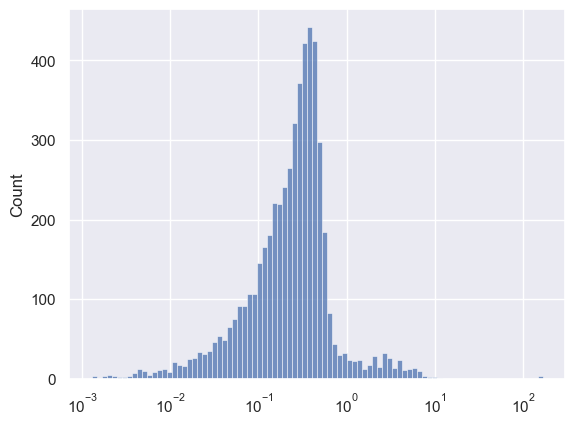

In [21]:
sns.histplot(x=r[r>1e-3], log_scale=True)

In [22]:
cache_fit = True

# least_squares give a deterministic result that depend on x0, the data, and the otimizer options
# hash the data as well as x0 to decide if we reuse last fit

filename = f"./results/linear-fit-{digest((data,x0))}.npy"

if cache_fit and path.isfile(filename):
    opt = load(filename)
else:
    opt = scipy.optimize.least_squares(residual, x0, loss="soft_l1", xtol=None, verbose=2) 
    
    # save result and remobe some stuff we don't neeed to save.
    del opt.jac
    del opt.active_mask
    del opt.fun
    
    save(filename, opt)

In [23]:
opt

    message: `ftol` termination condition is satisfied.
    success: True
     status: 2
          x: [ 2.000e-01  1.998e-01 ...  2.196e-01  2.194e-01]
       cost: 799.4312604468034
       grad: [ 5.758e-04  1.138e-03 ...  1.822e-05 -8.821e-06]
 optimality: 1.1371311717666686
       nfev: 48
       njev: 35

count    5.388000e+03
mean     3.978558e-01
std      6.917533e-01
min      3.637979e-11
25%      1.296895e-01
50%      2.662102e-01
75%      4.155951e-01
max      9.533027e+00
dtype: float64

<Axes: ylabel='Count'>

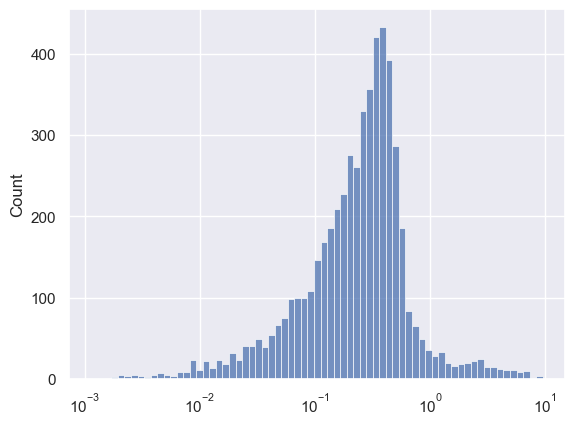

In [24]:
r_opt = np.abs(residual(opt.x))
pd.Series(r_opt).describe()
sns.histplot(x=r_opt[r_opt>1e-3], log_scale=True)

In [25]:
sol = unpack(opt.x, unpack_info)

tabledict(sol)

Nature Ingredient Finding,0.2000210514870304
Nature Main Skill Chance,0.1998389649235229
Nature Energy Recovery,0.08008299614264026
Pokemons ing fractions,[0.25625513 0.25460266 0.26579156 ... 0.180007 0.20055264 0.21654638]
Pokemons skill products,[16.73803176 16.70894152 18.4375153 ... 44.71716994 12.8028726 15.28262427]
Charge Strength S,[0.74771521 0.32191942]
Charge Strength M,[0.74495893 0.32274631]
Ingredient Magnet S,[0.74546144 0.32268103]
Cooking Power-Up S,[0.74536176 0.32257935]
Extra Helpful S,[0.74524399 0.32267218]
Charge Energy S,[0.74741948 0.32202684]


In [26]:
# Format ing% and skillProduct pretty

res = pd.DataFrame({"Pokemon":pokedex["Pokemon"], "ing%": sol["Pokemons ing fractions"]*100.0, "skill% * skillValue": sol["Pokemons skill products"] })
res.set_index("Pokemon")

,ing%,skill% * skillValue
Pokemon,,
Bulbasaur,25.625513,16.738032
Ivysaur,25.460266,16.708942
Venusaur,26.579156,18.437515
Charmander,20.043111,9.687362
Charmeleon,22.670141,14.058159
Charizard,22.421558,14.013919
Squirtle,27.003559,17.633087
Wartortle,27.062827,17.582587
Blastoise,27.462191,18.442226


In [27]:
# Format main skill growth per level 

growth_display = {}
levels = np.array(list(range(2,7)))
growth_display["Level"] = levels

for record in mainskills.to_dict(orient='records') :   
    
    skillname = record["Skill"]
    params = sol[skillname]
    growth_display[skillname] = params[0]*np.exp(params[1]*levels)
    
df = pd.DataFrame(growth_display)
df.set_index("Level")


,Charge Strength S,Charge Strength M,Ingredient Magnet S,Cooking Power-Up S,Extra Helpful S,Charge Energy S,Energizing Cheer S,Energy for Everyone S,Dream Shard Magnet S,Metronome
Level,,,,,,,,,,
2,1.423482,1.420582,1.421354,1.420875,1.420915,1.423224,1.424541,1.421805,1.421824,1.421561
3,1.964082,1.961703,1.962641,1.961780,1.962017,1.963938,1.984412,1.963218,1.962204,1.963700
4,2.709989,2.708944,2.710064,2.708600,2.709178,2.710081,2.764323,2.710796,2.707962,2.712593
5,3.739171,3.740822,3.742124,3.739722,3.740867,3.739700,3.850753,3.743047,3.737154,3.747091
6,5.159210,5.165757,5.167217,5.163375,5.165436,5.160494,5.364172,5.168371,5.157502,5.176112


In [28]:
# What are the worst points ?

df = data[["Pokemon","ID","Level","MS lvl","NatureP","NatureN","Sub Skill 1","Sub Skill 2","RP"]].copy()

df["fit"] = RP(opt.x)
df["error"] = residual(opt.x)
df["error2"] = df["error"]**2

df = df.sort_values("error2", ascending = False)
df.head(100)

,Pokemon,ID,Level,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
324,Charizard,CharizardMild276Helping Speed MSkill Level Up M,27.0,6,Ingredient Finding,Energy Recovery,Helping Speed M,Skill Level Up M,1514.0,1504.466973,9.533027,90.878610
2087,Togekiss,TogekissGentle103Skill Trigger M,10.0,3,Main Skill Chance,Energy Recovery,Skill Trigger M,,1282.0,1272.639323,9.360677,87.622279
507,Charmeleon,CharmeleonQuiet252Inventory Up MSleep EXP Bonus,25.0,2,Ingredient Finding,Exp Gains,Inventory Up M,Sleep EXP Bonus,1063.0,1054.459695,8.540305,72.936802
346,Charizard,CharizardRash273Helping bonusHelping Speed M,27.0,3,Ingredient Finding,Main Skill Chance,Helping bonus,Helping Speed M,1440.0,1431.499190,8.500810,72.263779
1773,Raticate,RaticateBrave281Inventory Up MSleep EXP Bonus,28.0,1,Speed of Help,EXP Gains,Inventory Up M,Sleep EXP Bonus,1097.0,1088.756127,8.243873,67.961436
270,Butterfree,ButterfreeImpish265Skill Level Up MSleep EXP B...,26.0,5,Energy Recovery,Ingredient Finding,Skill Level Up M,Sleep EXP Bonus,1404.0,1411.239340,-7.239340,52.408042
1996,Sudowoodo,SudowoodoHasty162Berry Finding S,16.0,2,EXP Gains,Energy Recovery,Berry Finding S,,743.0,750.048290,-7.048290,49.678387
2570,Butterfree,ButterfreeSassy102Helping bonus,10.0,2,Main Skill Chance,EXP Gains,Helping bonus,,816.0,809.271198,6.728802,45.276775
1341,Leafeon,LeafeonRelaxed102Inventory Up M,10.0,2,Energy Recovery,EXP Gains,Inventory Up M,,944.0,937.316139,6.683861,44.673996
230,Butterfree,ButterfreeCareful103Berry Finding S,10.0,3,Main Skill Chance,Ingredient Finding,Berry Finding S,,910.0,903.352331,6.647669,44.191501


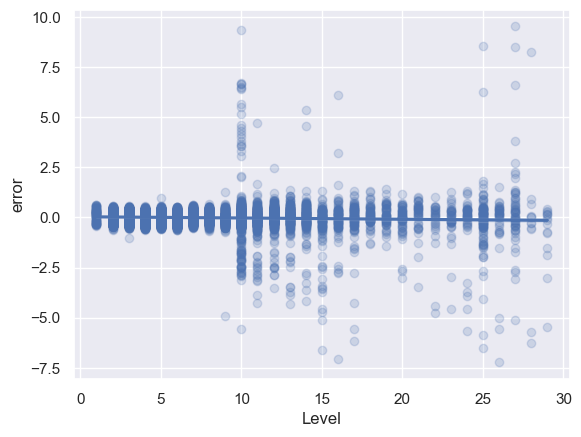

In [29]:
# Plot error vs level

err = df[["Level","error"]]
g = sns.regplot(data=err, x="Level", y="error", x_jitter=0, scatter_kws={'alpha':0.2})

In [30]:
# Do we have a slope ?

linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])

tableobj(linearfit)

intercept,0.0343937
intercept_stderr,0.0197054
pvalue,0.000387131
rvalue,-0.0483285
slope,-0.0062076
stderr,0.00174816


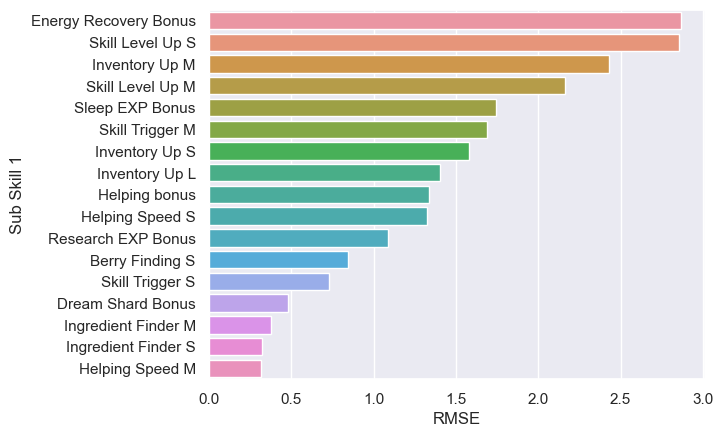

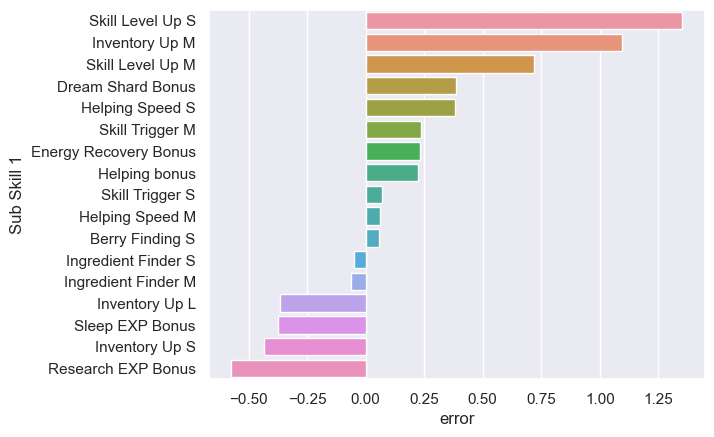

In [31]:
# Let's see what happens at level 10

subskill_err = ( df[["Level", "Sub Skill 1", "error", "error2"]][df["Level"]==10]
                .groupby("Sub Skill 1")
                .mean()
                .sort_values("error2", ascending = False)
                .reset_index() )

subskill_err["RMSE"] = np.sqrt(subskill_err["error2"])

_ = plt.figure()
_ = sns.barplot(data=subskill_err, y="Sub Skill 1", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=subskill_err.sort_values("error", ascending = False), y="Sub Skill 1", x="error")


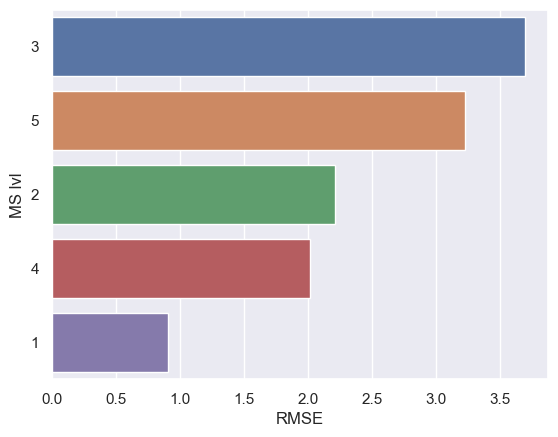

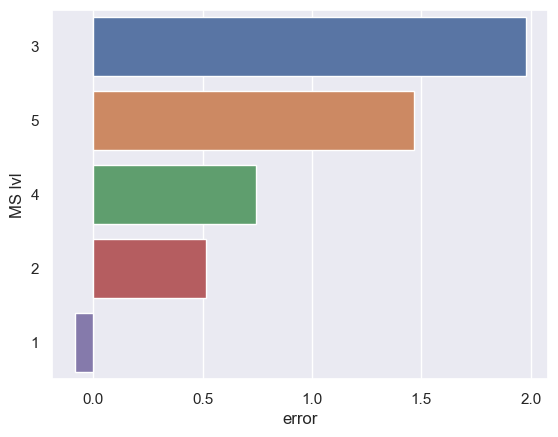

In [32]:
mslvl_err = ( df[["Level", "MS lvl", "error", "error2"]][df["Level"]==10]
                .groupby("MS lvl")
                .mean()
                .sort_values("error2", ascending = False)
                .reset_index() )

mslvl_err["RMSE"] = np.sqrt(mslvl_err["error2"])
mslvl_err["MS lvl"] = mslvl_err["MS lvl"].astype(str)

_ = plt.figure()
_ = sns.barplot(data=mslvl_err, y="MS lvl", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=mslvl_err.sort_values("error", ascending = False), y="MS lvl", x="error")


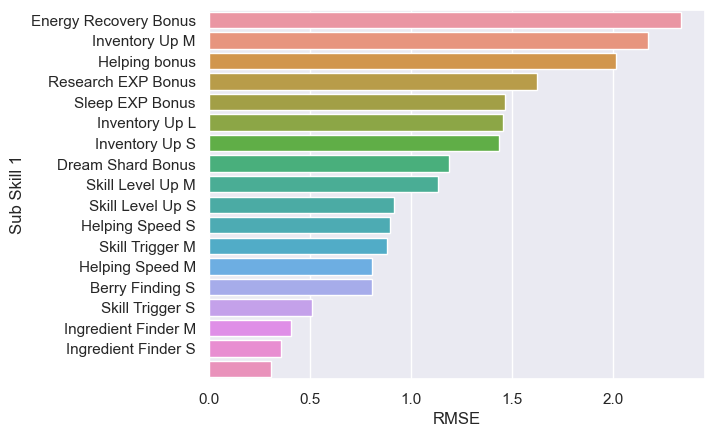

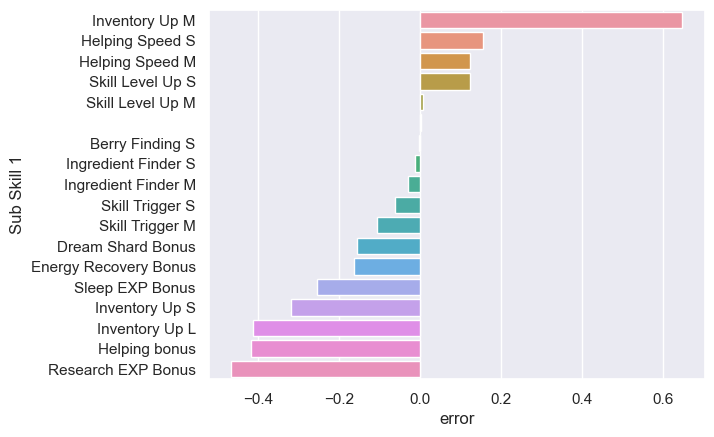

In [33]:
# Do we have more error in some skills ?

errorbyskill1 = (df[["Sub Skill 1","error","error2"]]
                .groupby("Sub Skill 1")
                .mean()
                .sort_values("error2", ascending = False)
                #.rename(columns={"error":"avg abs error"})
                .reset_index() )

errorbyskill1["RMSE"] = np.sqrt(errorbyskill1["error2"])
    
_ = plt.figure()
_ = sns.barplot(data=errorbyskill1, y="Sub Skill 1", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=errorbyskill1.sort_values("error", ascending = False), y="Sub Skill 1", x="error")

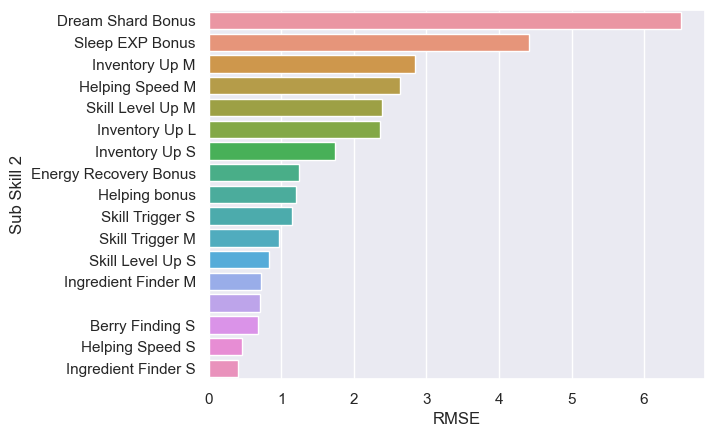

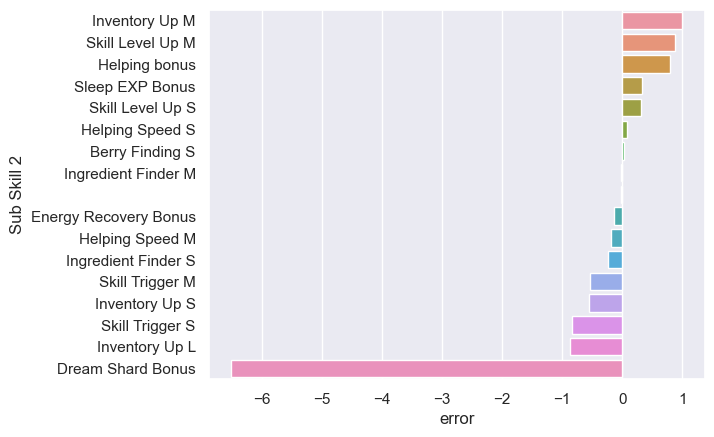

In [34]:
errorbyskill2 = (df[["Sub Skill 2","error","error2"]]
                .groupby("Sub Skill 2")
                .mean()
                .sort_values("error2", ascending = False)
                #.rename(columns={"error":"avg abs error"})
                .reset_index() )

errorbyskill2["RMSE"] = np.sqrt(errorbyskill2["error2"])
    
_ = plt.figure()
_ = sns.barplot(data=errorbyskill2, y="Sub Skill 2", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=errorbyskill2.sort_values("error", ascending = False), y="Sub Skill 2", x="error")